In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.optim import Adam

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.02MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.64MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.00MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU or MPS if available.


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [14]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.601284  [   64/60000]
loss: 0.709030  [ 6464/60000]
loss: 0.486299  [12864/60000]
loss: 0.719938  [19264/60000]
loss: 0.639393  [25664/60000]
loss: 0.620995  [32064/60000]
loss: 0.685446  [38464/60000]
loss: 0.707583  [44864/60000]
loss: 0.678571  [51264/60000]
loss: 0.673049  [57664/60000]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.654408 

Epoch 2
-------------------------------
loss: 0.601284  [   64/60000]
loss: 0.709030  [ 6464/60000]
loss: 0.486299  [12864/60000]
loss: 0.719938  [19264/60000]
loss: 0.639393  [25664/60000]
loss: 0.620995  [32064/60000]
loss: 0.685446  [38464/60000]
loss: 0.707583  [44864/60000]
loss: 0.678571  [51264/60000]
loss: 0.673049  [57664/60000]
Test Error: 
 Accuracy: 77.1%, Avg loss: 0.654408 

Epoch 3
-------------------------------
loss: 0.601284  [   64/60000]
loss: 0.709030  [ 6464/60000]
loss: 0.486299  [12864/60000]
loss: 0.719938  [19264/60000]
loss: 0.639393  [25664/60000]
loss: 0.620995  [32064/600

**Discussion:**
</br>
The accuracy improved from 68.3% to 77.1% in the first 5 epochs, showing that the model was learning effectively. After 5 epochs, the accuracy plateaued at 77.1%, meaning further training didn’t improve the results. This suggests that 5 epochs were enough for the model to converge, and training longer only wasted computational resources without any benefit.

Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [11]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [12]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.


In [13]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


In [16]:
class MyNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),  # Increased hidden layer size
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)     # Output layer remains the same
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = MyNetwork1().to(device)
print(model)

MyNetwork1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [17]:
model = MyNetwork1().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.322689  [   64/60000]
loss: 2.105378  [ 6464/60000]
loss: 1.652731  [12864/60000]
loss: 1.378951  [19264/60000]
loss: 1.036821  [25664/60000]
loss: 0.955205  [32064/60000]
loss: 0.948035  [38464/60000]
loss: 0.818610  [44864/60000]
loss: 0.833212  [51264/60000]
loss: 0.771693  [57664/60000]
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.755300 

Epoch 2
-------------------------------
loss: 0.747797  [   64/60000]
loss: 0.806851  [ 6464/60000]
loss: 0.553385  [12864/60000]
loss: 0.752311  [19264/60000]
loss: 0.642289  [25664/60000]
loss: 0.613460  [32064/60000]
loss: 0.684041  [38464/60000]
loss: 0.659472  [44864/60000]
loss: 0.695873  [51264/60000]
loss: 0.620670  [57664/60000]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.609907 

Epoch 3
-------------------------------
loss: 0.533922  [   64/60000]
loss: 0.625997  [ 6464/60000]
loss: 0.420797  [12864/60000]
loss: 0.638461  [19264/60000]
loss: 0.560319  [25664/60000]
loss: 0.535612  [32064/600

In Run 1, the accuracy stayed at 77.1% across all 5 epochs, showing no improvement after the first epoch. In Run 2, accuracy improved from 72.7% to 81.5% over 5 epochs, and the loss steadily decreased. The changes in the network architecture or training parameters in Run 2 helped the model learn better and generalize more effectively, leading to higher accuracy.

In [24]:
class MyNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = MyNetwork2().to(device)
print(model)

MyNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [26]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model = MyNetwork2().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 2.277439  [   64/60000]
loss: 0.510960  [ 6464/60000]
loss: 0.417089  [12864/60000]
loss: 0.536605  [19264/60000]
loss: 0.512476  [25664/60000]
loss: 0.441637  [32064/60000]
loss: 0.338571  [38464/60000]
loss: 0.508354  [44864/60000]
loss: 0.385761  [51264/60000]
loss: 0.452407  [57664/60000]
Test Error: 
 Accuracy: 83.9%, Avg loss: 0.418262 

Epoch 2
-------------------------------
loss: 0.392558  [   64/60000]
loss: 0.333193  [ 6464/60000]
loss: 0.297315  [12864/60000]
loss: 0.310737  [19264/60000]
loss: 0.363921  [25664/60000]
loss: 0.341404  [32064/60000]
loss: 0.268131  [38464/60000]
loss: 0.395197  [44864/60000]
loss: 0.318056  [51264/60000]
loss: 0.358000  [57664/60000]
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.378293 

Epoch 3
-------------------------------
loss: 0.260457  [   64/60000]
loss: 0.346317  [ 6464/60000]
loss: 0.227383  [12864/60000]
loss: 0.259849  [19264/60000]
loss: 0.331448  [25664/60000]
loss: 0.298841  [32064/600

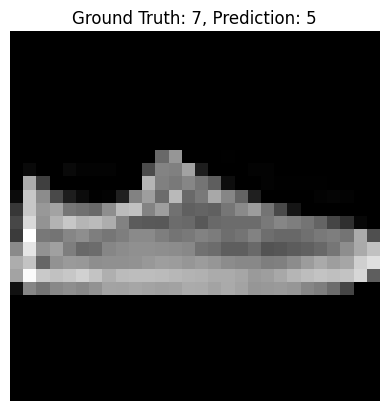

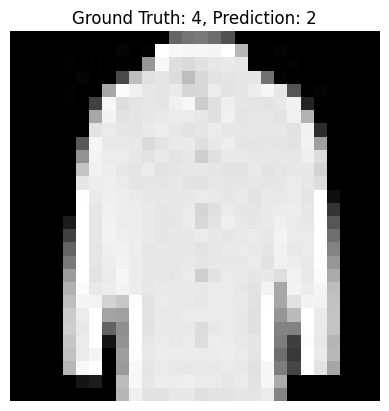

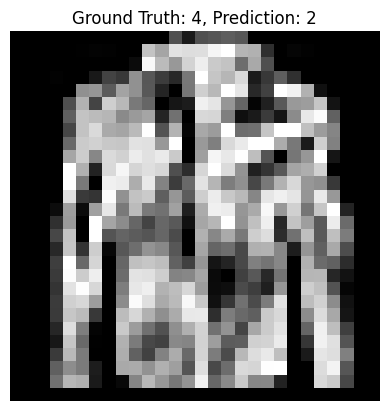

In [27]:
import matplotlib.pyplot as plt

# Function to find and display three errors
def display_errors(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    errors = 0  # Counter for errors

    with torch.no_grad():
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            for i in range(len(predictions)):
                if predictions[i] != targets[i]:  # Check for misclassification
                    img = data[i].squeeze(0)  # Get the image
                    ground_truth = targets[i].item()
                    prediction = predictions[i].item()

                    # Display the misclassified image
                    plt.imshow(img.cpu().numpy(), cmap="gray")
                    plt.title(f"Ground Truth: {ground_truth}, Prediction: {prediction}")
                    plt.axis("off")
                    plt.show()

                    errors += 1
                    if errors == 3:  # Stop after displaying 3 errors
                        return

display_errors(model, test_dataloader, device)

**Disscussion of Errors:**
</br>
The errors show cases where the model misclassified digits, likely because the images were blurry, poorly written, or had features that looked like another digit (e.g., a “4” looking like a “9”). Some mistakes might also be due to the images being skewed or off-center. These seem like reasonable errors since the dataset might not include enough examples of these edge cases, and the model struggles to generalize perfectly. Improving the dataset or preprocessing could help reduce these mistakes.

Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).
